# Empirical Asset Pricing - PS6

Maximilian Huber

## Task 1

In [31]:
# load the data
using CSV, DataFrames, Plots, LatexPrint; gr();
options = CSV.read("./Data/37d329c9b7427334.csv", dateformat = "yyyymmdd", allowmissing=:none, 
    use_mmap = false, 
    types = [Date, Date, Char, Int32, Float32, Float32, Int32, Int8, String, Char])

delete!(options, :issuer)
delete!(options, :exercise_style)
delete!(options, :index_flag)

options[:cp_flag] = options[:cp_flag] .== 'C'
rename!(options, :cp_flag => :call)

options[:strike_price] = options[:strike_price] ./ 1000

sort!(options, :date)

head(options)

spx = CSV.read("./Data/7ec2694205f0f4e1.csv", dateformat = "yyyymmdd", allowmissing=:none, 
    use_mmap = false, types = [Date, Float32])
rename!(spx, :DATE => :date)
trading_dates = unique(options[:date])
spx = vcat([spx[searchsortedfirst(spx[:date], d), :] for d in trading_dates]...)
head(spx);

## Preliminaries
I observed that the price of options on the day that they expire is odd. If one bought or sold options on the day of their expiry one could frequently make profits:

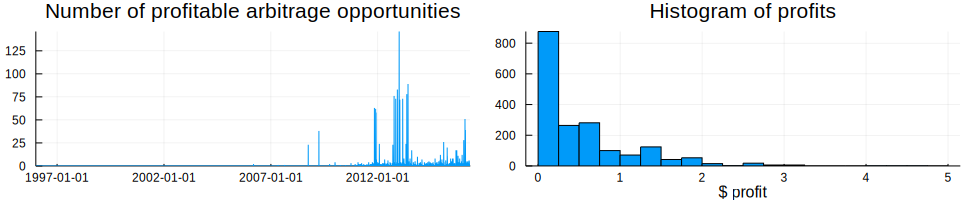

In [32]:
# find arbitrage opportunities (buy an option and exercise it, or sell an option and fulfill it)
expired = options[options[:date] .== options[:exdate], :] #on the day of expiry
incorrect = expired[
    ((max.((-1.0) .^ (.!expired[:call]) .* ([spx[searchsortedfirst(spx[:date], d), :spindx] for d in expired[:date]] -
       expired[:strike_price]), 0) - expired[:best_offer]) .> 0) .|  #buy an option and exercise it if it is good
    ((min.((-1.0) .^ (expired[:call]) .* ([spx[searchsortedfirst(spx[:date], d), :spindx] for d in expired[:date]] -
       expired[:strike_price]), 0) + expired[:best_bid]) .> 0) , :] #sell an option and fulfill if it is exercised

p1 = plot(trading_dates, [length(searchsorted(incorrect[:date], d)) for d in trading_dates], title = "Number of profitable arbitrage opportunities", label = "")
p2 = histogram(vcat((max.((-1.0) .^ (.!expired[:call]) .* ([spx[searchsortedfirst(spx[:date], d), :spindx] for d in expired[:date]] -
       expired[:strike_price]), 0) - expired[:best_offer])[(max.((-1.0) .^ (.!expired[:call]) .* ([spx[searchsortedfirst(spx[:date], d), :spindx] for d in expired[:date]] -
       expired[:strike_price]), 0) - expired[:best_offer]) .> 0],  #buy an option and exercise it if it is good
    (min.((-1.0) .^ (expired[:call]) .* ([spx[searchsortedfirst(spx[:date], d), :spindx] for d in expired[:date]] -
       expired[:strike_price]), 0) + expired[:best_bid])[(min.((-1.0) .^ (expired[:call]) .* ([spx[searchsortedfirst(spx[:date], d), :spindx] for d in expired[:date]] -
       expired[:strike_price]), 0) + expired[:best_bid]) .> 0]), bins = 0:0.25:5, title = "Histogram of profits", label = "", xlab = "\$ profit")

plot(p1, p2, size=(980, 200))

I conclude that I will never want to use the price of an option on the day of its expiry. Hence, in (b) I choose a minimal duration to be a few days longer than the desired holding period.

## Writing Straddles
On every day for which there is options data available I sell one ATM call and and one ATM put and receive the `best_bid` price. I then look up the `best_offer` price of the respective options via `optionid` on the first day after the holding period ends.

I use two different schemes to select the options that are sold, and then bought back in a month:
* a scheme that focuses on achieving at-the-money
* a scheme that focuses on achieving time-to-maturity

<b>Note:</b> The way the return is calculated is very important!

At first, I calculate returns as if the investor did not have to adhere to margin requirements. That is, there is no necessary deposit at a margin account. Hence, the formula for the return is:

$$R^\text{naive}_{t,t+1} = \frac{P^{\text{call}, i}_t + P^{\text{put}, j}_t}{P^{\text{call}, i}_{t+1} + P^{\text{put}, j}_{t+1}} - 1$$

Then, at the end of (b), (c), and (d) I report returns for a strategy where the margin account needs to have a balance of $M_t = \Big(P^{\text{call}, i}_t + P^{\text{put}, j}_t\Big)\Big(\frac{1}{1-0.8} - 1\Big)$. That is, the the balance on the margin account plus the proceeds from selling the options needs to be enough to cover five times the the current option price. This is motivated by the maximal observed loss of the strategy of $-0.7946$. The return is then:

$$R^\text{margin}_{t,t+1} = \frac{P^{\text{call}, i}_t + P^{\text{put}, j}_t - P^{\text{call}, i}_{t+1} - P^{\text{put}, j}_{t+1}}{M_t} + R^\text{risk free}_t$$

In [3]:
function ATM_focused_scheme(options, trading_dates; last_day = Date(2016, 3, 31), min_days = 33)
    
    N = findlast(trading_dates .<= last_day)
    
    ret = zeros(N)
    ret_margin = zeros(N)
    dist = zeros(N)
    idcall = zeros(Int32, N)
    idput = zeros(Int32, N)
    sdate = Array{Date, 1}(N)
    ttm = zeros(Dates.Day, N)

    for (i, d) in enumerate(trading_dates[1:N])
        
        ignore = 0 #in case there is no put/call pair with the strike closest to the index price, I start ignoring those options.
        selected = searchsorted(options[:date], d) #correct date        
        
        while true #break if search was successfull
            
            selected = searchsorted(options[:date], d)
            dist_price = abs.(options[selected, :strike_price] .- spx[i, :spindx])
            selected = selected[dist_price .≈ minimum(sort(dist_price)[(ignore+1):end])] #closested to ATM, possibly ignoring the closest
            selected = selected[options[selected, :strike_price] .== minimum(options[selected, :strike_price])] #if two strike levels are equally close to ATM
            selected = selected[(options[selected, :exdate] .- d) .>= Dates.Day(min_days)] #at least 33 days until maturity

            if length(selected) < 2 #no two closest contracts that have a high enough duration
                ignore += 1
                continue
            end

            earliest_selected = selected[options[selected, :exdate] .== minimum(options[selected, :exdate])] #earliest exp

            if length(earliest_selected) == 1 #only one contract! increase the maturity
                earliest_selected = selected[options[selected, :exdate] .== minimum(sort(options[selected, :exdate])[2:end])] #earliest exp
            end
                      
            selected = earliest_selected
            
            sell_date = trading_dates[findfirst((trading_dates .- d) .>= Dates.Day(min_days-4))]
            sell_options = options[searchsorted(options[:date], sell_date), :]
            
            try
                ret[i]::Float64 = Float64(sum(options[selected, :best_bid]) / 
                    (sell_options[sell_options[:optionid] .== options[selected[1], :optionid], :best_offer][1] + 
                    sell_options[sell_options[:optionid] .== options[selected[2], :optionid], :best_offer][1]) - 1)
                ret_margin[i]::Float64 = (sum(options[selected, :best_bid]) - (sell_options[sell_options[:optionid] .== options[selected[1], :optionid], :best_offer][1] + 
                    sell_options[sell_options[:optionid] .== options[selected[2], :optionid], :best_offer][1])) / (sum(options[selected, :best_bid]) * 4)
            catch
                ignore += 1
                warn("No sell data at $i $d $sell_date for $(options[selected[1], :optionid]) $(options[selected[2], :optionid])")
            finally
                sdate[i] = sell_date
                idcall[i] = options[selected, :][options[selected, :call], :optionid][1]
                idput[i] = options[selected, :][.!options[selected, :call], :optionid][1]
                dist[i] = (options[selected, :strike_price][1] - spx[i, :spindx]) / spx[i, :spindx] * 100
                ttm[i] = options[selected, :exdate][1] - d

                break
            end
        end
    end
    
    return DataFrame([trading_dates[1:N], ret, idcall, idput, sdate, dist, ttm, ret_margin], [:date, :return, :idcall, :idput, :sdate, :dist, :ttm, :return_margin])
end

ATM_focused_scheme (generic function with 1 method)

In [4]:
function TTM_focused_scheme(options, trading_dates; last_day = Date(2016, 3, 31), min_days = 33)
    
    N = findlast(trading_dates .<= last_day)
    
    ret = zeros(N)
    dist = zeros(N)
    idcall = zeros(Int32, N)
    idput = zeros(Int32, N)
    sdate = Array{Date, 1}(N)
    ttm = zeros(Dates.Day, N)

    
    for (i, d) in enumerate(trading_dates[1:N])
               
        extra_days = 0 #in case there is no put/call pair with the strike closest to the index price, I start ignoring those options.
        selected = searchsorted(options[:date], d) #correct date        

        while true
            selected = searchsorted(options[:date], d) #correct date

            selected = selected[(options[selected, :exdate] .- d) .>= Dates.Day(min_days + extra_days)] #at least some days until maturity
            selected = selected[options[selected, :exdate] .== minimum(options[selected, :exdate])] #earliest exp

            dist_price = abs.(options[selected, :strike_price] .- spx[i, :spindx])
            strike_selected = selected[dist_price .≈ minimum(dist_price)] #closested to ATM
            strike_selected = strike_selected[options[strike_selected, :strike_price] .== minimum(options[strike_selected, :strike_price])] #if two strike levels are equally close to ATM

            if length(strike_selected) == 1 #only one contract available! choose different strike!
                strike_selected = selected[dist_price .≈ minimum(sort(dist_price)[2:end])]
                strike_selected = strike_selected[options[strike_selected, :strike_price] .== minimum(options[strike_selected, :strike_price])] #if two strike levels are equally close to ATM
            end

            if length(strike_selected) != 2
                warn("Had to increase time-to-maturity because not enough contracts at $d")
                extra_days += 21
                continue
            else
                selected = strike_selected
                break
            end
        end
       
        #write info about sold options
        idcall[i] = options[selected, :][options[selected, :call], :optionid][1]
        idput[i] = options[selected, :][.!options[selected, :call], :optionid][1]
        dist[i] = (options[selected, :strike_price][1] - spx[i, :spindx]) / spx[i, :spindx] * 100
        ttm[i] = options[selected, :exdate][1] - d 
             
        #select only relevent options, increases performance!
        sell_options = searchsortedfirst(options[:date], d + Dates.Day(min_days - 4)):searchsortedlast(options[:date], d + Dates.Day(min_days + 14))
        
        #find buy-back date: earliest date where both have a price!
        sell_date = minimum(intersect(options[sell_options, :][(options[sell_options, :optionid] .== idcall[i]) .& (options[sell_options, :date] .>= d + Dates.Day(min_days - 4)), :date],
            options[sell_options, :][(options[sell_options, :optionid] .== idput[i]) .& (options[sell_options, :date] .>= d + Dates.Day(min_days - 4)), :date]))

        sell_options = options[searchsorted(options[:date], sell_date), :]
     
        ret[i]::Float64 = Float64(sum(options[selected, :best_bid]) / 
            (sell_options[sell_options[:optionid] .== options[selected[1], :optionid], :best_offer][1] + 
            sell_options[sell_options[:optionid] .== options[selected[2], :optionid], :best_offer][1]) - 1)
        
        sdate[i] = sell_date
    end
    
    return DataFrame([trading_dates[1:N], ret, idcall, idput, sdate, dist, ttm], [:date, :return, :idcall, :idput, :sdate, :dist, :ttm])
end

TTM_focused_scheme (generic function with 1 method)

### (b)

#### Evaluation of the Strategy
I evaluate both schemes:

In [5]:
returns_atm = ATM_focused_scheme(options, trading_dates);
returns_ttm = TTM_focused_scheme(options, trading_dates);

There are not many errors keeping in mind that I evaluate the strategy for every day. 

The ATM-focused scheme is more concentrated around the zero percent deviation from ATM, while the TTM-focused scheme has shorter time-to-maturity. The holding periods are equal. And the two scheme regularly select different options:

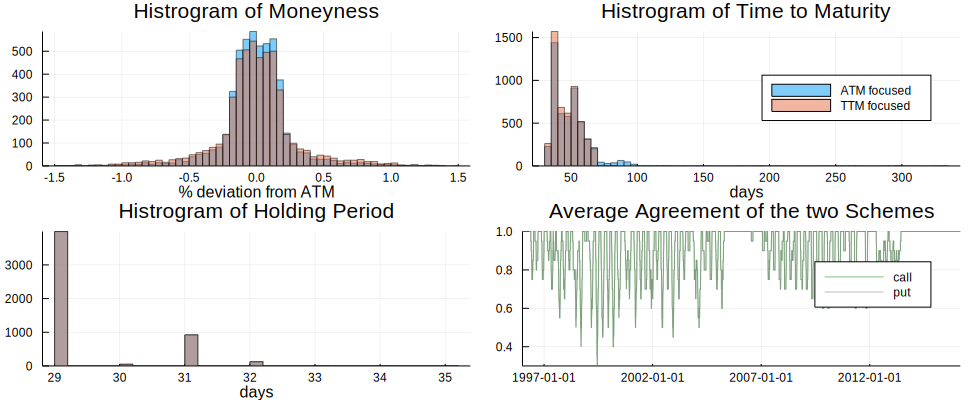

In [6]:
# plots to assess how well the strategy is fulfilled
p1 = histogram(returns_atm[:dist], xlab = "% deviation from ATM", label = "", title = "Histrogram of Moneyness", alpha = 0.5)
histogram!(p1, returns_ttm[:dist], label = "", alpha = 0.5)
p2 = histogram(Dates.value.(returns_atm[:ttm]), xlab = "days", label = "ATM focused", title = "Histrogram of Time to Maturity", alpha = 0.5, legend = :topright)
histogram!(p2, Dates.value.(returns_ttm[:ttm]), label = "TTM focused", nbins=20, alpha = 0.5)
p3 = histogram(Dates.value.(returns_atm[:sdate] .- returns_atm[:date]), xlab = "days", label = "", title = "Histrogram of Holding Period", alpha = 0.5)
histogram!(p3, Dates.value.(returns_ttm[:sdate] .- returns_ttm[:date]), xlab = "days", label = "", title = "Histrogram of Holding Period", alpha = 0.5)

p4 = plot(returns_atm[1:end-19, :date], [mean(((returns_atm[:idcall] .- returns_ttm[:idcall]) .== 0)[i:i+19]) for i in 1:size(returns_atm, 1)-19], color = :green, label = "call", alpha = 0.5, title = "Average Agreement of the two Schemes", legend = :bottomright)
plot!(p4, returns_atm[1:end-19, :date], [mean(((returns_atm[:idput] .- returns_ttm[:idput]) .== 0)[i:i+19]) for i in 1:size(returns_atm, 1)-19], color = :grey, label = "put", alpha = 0.5)

plot(p1, p2, p3, p4, size=(980, 400))

I execute the trading strategy on the <b>end of every month</b>. The two schemes perform very similarly:

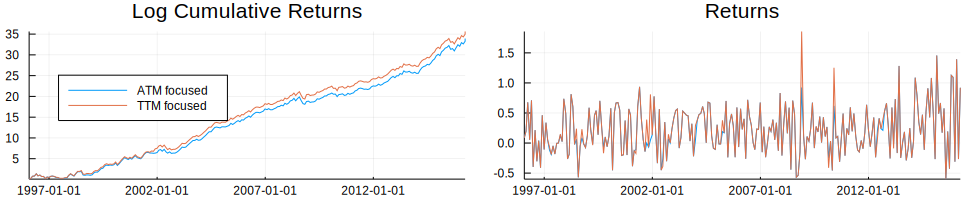

In [7]:
# plot the performance
trading_dates_last = unique(Dates.lastdayofmonth.(trading_dates)) #desired months
trading_dates_last = [maximum(returns_atm[returns_atm[:date] .<= month, :date]) for month in trading_dates_last]

p1 = plot(trading_dates_last, (cumsum(log.([returns_atm[returns_atm[:date] .== d, :return][1] for d in trading_dates_last] + 1))), label = "ATM focused", legend = :topleft, title = "Log Cumulative Returns")
plot!(p1, trading_dates_last, (cumsum(log.([returns_ttm[returns_ttm[:date] .== d, :return][1] for d in trading_dates_last] + 1))), label = "TTM focused")

p2 = plot(trading_dates_last, [returns_atm[returns_atm[:date] .== d, :return][1] for d in trading_dates_last], label = "", legend = :bottomright, title = "Returns")
plot!(p2, trading_dates_last, [returns_ttm[returns_ttm[:date] .== d, :return][1] for d in trading_dates_last], label = "")

plot(p1, p2, size=(980, 200))

#### Returns with a Conservative Margin Requirement
The returns of the ATM-focused scheme with a four-fold margin requirement are much more realistic:

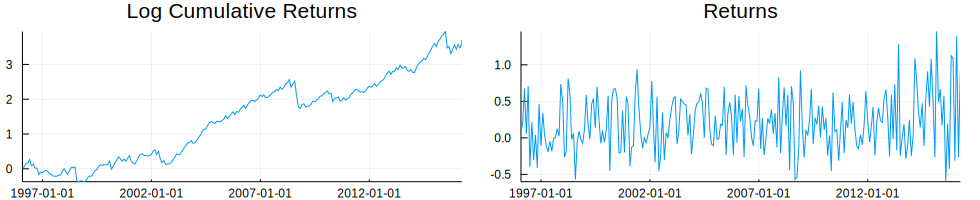

In [8]:
# plot the performance
p1 = plot(trading_dates_last, (cumsum(log.([returns_atm[returns_atm[:date] .== d, :return_margin][1] for d in trading_dates_last] + 1))), label = "", legend = :topleft, title = "Log Cumulative Returns")
p2 = plot(trading_dates_last, [returns_atm[returns_atm[:date] .== d, :return][1] for d in trading_dates_last], label = "", legend = :bottomright, title = "Returns")

plot(p1, p2, size=(980, 200))

### (c)

In [9]:
returns_atm1y = ATM_focused_scheme(options, trading_dates, last_day = Date(2015, 3, 31), min_days = 368)
returns_ttm1y = TTM_focused_scheme(options, trading_dates, last_day = Date(2015, 3, 31), min_days = 368);

There are some more instances where there is no price at the desired buy-back date and quite a few times there are not enough contracts traded on a sell day.

Again, the ATM-focused scheme yields lower deviation from ATM, while the TTM-focused scheme has no time-to-maturity outliers but has moneyness outliers. The strategies agree quite often, but with episodes of significant deviation:

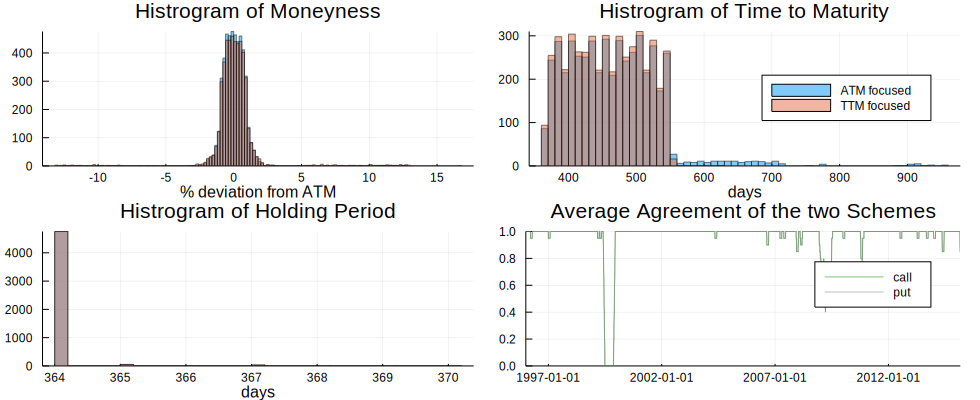

In [10]:
# plots to assess how well the strategy is fulfilled
p1 = histogram(returns_atm1y[:dist], xlab = "% deviation from ATM", label = "", title = "Histrogram of Moneyness", alpha = 0.5)
histogram!(p1, returns_ttm1y[:dist], label = "", alpha = 0.5)
p2 = histogram(Dates.value.(returns_atm1y[:ttm]), xlab = "days", label = "ATM focused", title = "Histrogram of Time to Maturity", alpha = 0.5, legend = :topright)
histogram!(p2, Dates.value.(returns_ttm1y[:ttm]), label = "TTM focused", nbins=40, alpha = 0.5)
p3 = histogram(Dates.value.(returns_atm1y[:sdate] .- returns_atm1y[:date]), xlab = "days", label = "", title = "Histrogram of Holding Period", alpha = 0.5)
histogram!(p3, Dates.value.(returns_ttm1y[:sdate] .- returns_ttm1y[:date]), xlab = "days", label = "", title = "Histrogram of Holding Period", alpha = 0.5)

p4 = plot(returns_atm1y[1:end-19, :date], [mean(((returns_atm1y[:idcall] .- returns_ttm1y[:idcall]) .== 0)[i:i+19]) for i in 1:size(returns_atm1y, 1)-19], color = :green, label = "call", alpha = 0.5, title = "Average Agreement of the two Schemes", legend = :bottomright)
plot!(p4, returns_atm1y[1:end-19, :date], [mean(((returns_atm1y[:idput] .- returns_ttm1y[:idput]) .== 0)[i:i+19]) for i in 1:size(returns_atm1y, 1)-19], color = :grey, label = "put", alpha = 0.5)

plot(p1, p2, p3, p4, size=(980, 400))

If I chose to execute the strategy on the last trading date of every year, the performance would be:

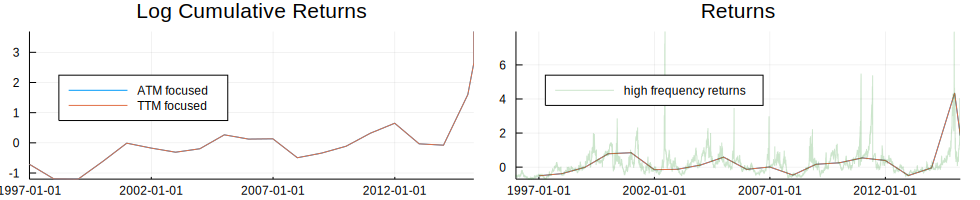

In [11]:
# plot the performance
trading_dates_last = unique(Dates.lastdayofyear.(trading_dates)) #desired dates
trading_dates_last = [maximum(returns_atm1y[returns_atm1y[:date] .<= month, :date]) for month in trading_dates_last]

p1 = plot(trading_dates_last, (cumsum(log.([returns_atm1y[returns_atm1y[:date] .== d, :return][1] for d in trading_dates_last] + 1))), label = "ATM focused", legend = :topleft, title = "Log Cumulative Returns")
plot!(p1, trading_dates_last, (cumsum(log.([returns_ttm1y[returns_ttm1y[:date] .== d, :return][1] for d in trading_dates_last] + 1))), label = "TTM focused")

p2 = plot(trading_dates_last, [returns_atm1y[returns_atm1y[:date] .== d, :return][1] for d in trading_dates_last], label = "", legend = :bottomright, title = "Returns")
plot!(p2, trading_dates_last, [returns_ttm1y[returns_ttm1y[:date] .== d, :return][1] for d in trading_dates_last], label = "")
plot!(p2, trading_dates[1:4843], [returns_atm1y[returns_atm1y[:date] .== d, :return][1] for d in trading_dates[1:4843]], label = "high frequency returns", legend = :topleft, title = "Returns", alpha = 0.2, color = :green)

plot(p1, p2, size=(980, 200))

Let me compare annual returns, that is I report the returns from the monthly strategy started on any given day and repeated 11 times in the following year.

In [12]:
# plot the histogram of annualized returns
histogram([prod([returns_atm[searchsortedlast(returns_atm[:date], d + Dates.Month(m)), :return] for m in 0:11] .+ 1) - 1 for d in returns_atm[:date][1:4843]] * 100, label = "one month", title = "Annual Returns by Holding Period", alpha = 0.5, xlab = "% return", xlim = (-100, 2500), nbins = 16000)
histogram!(returns_atm1y[:return] .* 100, label = "one year", alpha = 0.5, size=(980, 200))

This histogram suggests that the short-term volatility selling strategy is better than the long-term strategy.

#### Returns with a Conservative Margin Requirement

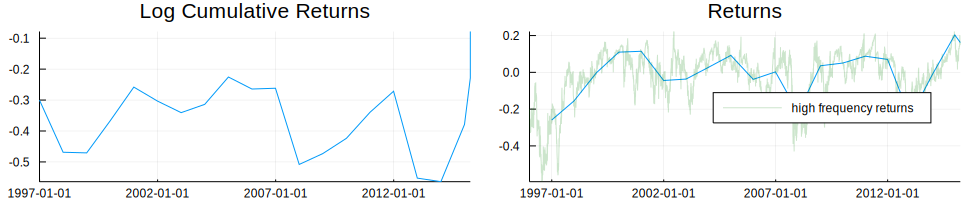

In [13]:
# plot the performance
p1 = plot(trading_dates_last, (cumsum(log.([returns_atm1y[returns_atm1y[:date] .== d, :return_margin][1] for d in trading_dates_last] + 1))), label = "", legend = :topleft, title = "Log Cumulative Returns")

p2 = plot(trading_dates_last, [returns_atm1y[returns_atm1y[:date] .== d, :return_margin][1] for d in trading_dates_last], label = "", legend = :bottomright, title = "Returns")
plot!(p2, trading_dates[1:4843], [returns_atm1y[returns_atm1y[:date] .== d, :return_margin][1] for d in trading_dates[1:4843]], label = "high frequency returns", legend = :bottomright, title = "Returns", alpha = 0.2, color = :green)

plot(p1, p2, size=(980, 200))

There is no money to be made selling long-term volatility!

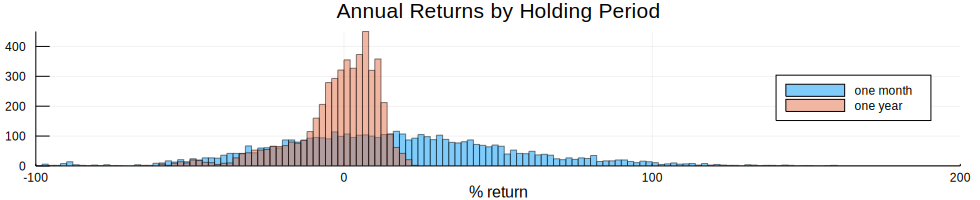

In [14]:
# plot the histogram of annualized returns
histogram([prod([returns_atm[searchsortedlast(returns_atm[:date], d + Dates.Month(m)), :return_margin] for m in 0:11] .+ 1) - 1 for d in returns_atm[:date][1:4843]] * 100, label = "one month", title = "Annual Returns by Holding Period", alpha = 0.5, xlab = "% return", xlim = (-100, 200), nbins = 160)
histogram!(returns_atm1y[:return_margin] .* 100, label = "one year", alpha = 0.5, size=(980, 200))

### (d) 


In [15]:
# load risk free rate
interest = CSV.read("./Data/interest.csv", dateformat = "yyyymm", allowmissing=:none, 
    types = [Date, Float64]);

I use the ATM-focused excess returns and calculate point estimates. The monthly returns are aggregate to yearly returns:

In [16]:
returns1m = ([prod([returns_atm[searchsortedlast(returns_atm[:date], d + Dates.Month(m)), :return] for m in 0:11] .+ 1) - 1 for d in returns_atm[:date][1:4843]]+1) ./ ([interest[searchsortedlast(interest[:date], d), :RF] for d in returns_atm[1:4843, :date]]/100 + 1) .- 1
returns1y = ((returns_atm1y[:return]+1) ./ ([interest[searchsortedlast(interest[:date], d), :RF] for d in returns_atm1y[:date]]/100 + 1) .- 1)[1:4843];

In [17]:
# point estimates with standard functions
df = DataFrame(Statistic = String[], Strategy_1m = Float64[], Strategy_1y = Float64[])
push!(df, ["Mean", mean(returns1m), mean(returns1y)])
push!(df, ["Std. Dev.", std(returns1m), std(returns1y)])

push!(df, ["Sharpe Ratio", mean(returns1m)/std(returns1m), mean(returns1y)/std(returns1y)])

df

#tabular(df, rounding=4);

\begin{array}{ccc}
\hline
Statistic & Strategy_{1m} & Strategy_{1y}\\
\hline
\text{Mean} & 12.2006 & 0.1919\\
\text{Std. Dev.} & 37.9006 & 0.6956\\
\text{Sharpe Ratio} & 0.3219 & 0.2759
\end{array}

But I need an approximate distribution, so I do joint GMM (i.e. both the monthly and yearly strategy in one estimation, this turns out not to be relevant) with the following moment function, where $\theta_1 = \mu_{1m}$, $\theta_2 = \sigma_{1m}$, $\theta_1 = \mu_{1y}$ and $\theta_2 = \sigma_{1y}$:

In [18]:
#operates on a single observation, w[1] = return_1m, w[2] = return_1y
function g(w, θ)
    [w[1] - θ[1], (w[1] - θ[1])^2 - θ[2]^2, w[2] - θ[3], (w[2] - θ[3])^2 - θ[4]^2]
end

g (generic function with 1 method)

In [19]:
# my standard GMM setup, with Newey-West HAC variance estimation
using Optim

function gn(w, θ)
    avg_g = zeros(length(θ))
    for t in 1:size(w, 1)
        avg_g += g(w[t, :], θ)
    end
    
    return avg_g/size(w, 1)
end

function gn_wrapper(W)
    N = size(W, 1)
    w = W
    return θ -> gn(w, θ)
end

function Qn(θ, gn_wrapped)
    1/2 * (gn_wrapped(θ)' * gn_wrapped(θ))[1]
end

function Qn(θ, gn_wrapped, W)
    1/2 * (gn_wrapped(θ)' * W * gn_wrapped(θ))[1]
end

function Shat_HAC(w, θ; Jn = 30)
    N = length(θ)
    
    Γ = zeros(N, N)
    Γ!(Γ, w, θ, j = 0)
    
    #0th lag
    Shat = copy(Γ)
    
    #all other lags
    for j in 1:Jn
        Γ .= zeros(N, N)
        Γ!(Γ, w, θ, j = j)
        Shat .+= (1 - j / (Jn + 1)) .* (Γ .+ Γ')
    end
    
    return Shat
end

function Γ!(Γ, w, θ; j = 0)
    for t in j+1:size(w, 1)
        Γ .+= g(w[t,:], θ) * g(w[t-j,:], θ)'
    end
    
    Γ .= Γ ./ (size(w, 1) - j)
end

Γ! (generic function with 1 method)

In [20]:
# standard efficient GMM procedure
function eff_GMM(W; Jn = 30)
    #first stage
    initial_θ = 0.5 * ones(4)
    lower = [-Inf, 0, -Inf, 0]
    upper = [Inf, Inf, Inf, Inf]
    
    gn_wrapped = gn_wrapper(W)
    obj = OnceDifferentiable(θ -> Qn(θ, gn_wrapped), initial_θ; autodiff = :forward)
    first_θ = Optim.minimizer(optimize(obj, initial_θ, lower, upper, Fminbox{LBFGS}()))

    #second stage
    obj = OnceDifferentiable(θ -> Qn(θ, gn_wrapped, Shat_HAC(W, first_θ, Jn = Jn)^(-1)), first_θ; autodiff = :forward)
    #obj.f(first_θ)
    second_θ = Optim.minimizer(optimize(obj, first_θ, lower, upper, 
        Fminbox{LBFGS}(), optimizer_o = Optim.Options(iterations = 100)))
    
    #asymptotic variance estimation
    G = ForwardDiff.jacobian(gn_wrapped, second_θ)
    Vhat = (G' * Shat_HAC(W, first_θ, Jn = Jn)^(-1) * G)^(-1)

    #return point estimates and sample std errors
    return [second_θ, Vhat/size(W, 1)] 
end

eff_GMM (generic function with 1 method)

In [21]:
result = eff_GMM(hcat(returns1m, returns1y), Jn = 30)

2-element Array{Array{Float64,N} where N,1}:
 [12.2006, 37.8966, 0.191947, 0.695524]                                                                                                                   
 [2.4026 9.18919 0.0295112 0.0416276; 9.18919 44.6641 0.114674 0.210015; 0.0295112 0.114674 0.00222891 0.0023596; 0.0416276 0.210015 0.0023596 0.00546273]

This yields:
$$\left[\begin{array}{c}
\mu_{1m}\\
\sigma_{1m}\\
\mu_{1y}\\
\sigma_{1y}
\end{array}\right]\sim\mathcal{N}\left(\left[\begin{array}{c}
12.2006\\
37.8966\\
0.19194\\
0.69552
\end{array}\right],\left[\begin{array}{cccc}
2.4026 & 9.18919 & 0.029511 & 0.041627\\
9.18919 & 44.6641 & 0.11467 & 0.210015\\
0.029511 & 0.11467 & 0.002228 & 0.002359\\
0.041627 & 0.21005 & 0.002359 & 0.005462
\end{array}\right]\right)$$

Applying the Delta-Method with $f(\theta) = \big[\frac{\theta_1}{\theta_2}, \, \frac{\theta_3}{\theta_4}\big]$:

In [22]:
f(θ) = [θ[1]/θ[2], θ[3]/θ[4]]

SR_result = [f(result[1]), ForwardDiff.jacobian(f, result[1]) * result[2] * ForwardDiff.jacobian(f, result[1])']

2-element Array{Array{Float64,N} where N,1}:
 [0.321944, 0.275974]                             
 [0.000776475 -8.96187e-6; -8.96187e-6 0.00277534]

That is:

$$\left[\begin{array}{c}
SR_{1m}\\
SR_{1y}
\end{array}\right]\sim\mathcal{N}\left(\left[\begin{array}{c}
0.32194\\
0.27597
\end{array}\right],\left[\begin{array}{cc}
0.0007764 & -0.000008\\
-0.000008 & 0.002775
\end{array}\right]\right)$$

Hence, the difference $f(\theta)=\theta_1-\theta_2$:

In [23]:
f(θ) = [θ[1] - θ[2]]

Diff_result = [f(SR_result[1]), ForwardDiff.jacobian(f, SR_result[1]) * SR_result[2] * ForwardDiff.jacobian(f, SR_result[1])']

2-element Array{Array{Float64,N} where N,1}:
 [0.04597]   
 [0.00356974]

That is:

$$\Delta SR = SR_{1m}-SR_{1y}\sim\mathcal{N}\left(0.04597,\,0.00357\right)$$

The $\mathcal{H}_0$ is that $\Delta SR \leq 0$, the $\mathcal{H}_1$ is that $\Delta SR \gt 0$. The test statistic is $\frac{\mu_{\Delta SR}}{\sigma_{\Delta SR}}$, and the corresponding p-value can be calculated by see how much mass there is below zero:

In [24]:
using Distributions
cdf(Normal(Diff_result[1][1], Diff_result[2][1]), 0.)

3.0048338873143014e-38

A clear rejection of the $\mathcal{H}_0$!

#### Results with a Conservative Margin Requirement

In [25]:
# point estimates with standard functions

returns1m = ([prod([returns_atm[searchsortedlast(returns_atm[:date], d + Dates.Month(m)), :return_margin] for m in 0:11] .+ 1) - 1 for d in returns_atm[:date][1:4843]]+1)  .- 1
returns1y = ((returns_atm1y[:return_margin]+1) .- 1)[1:4843];

df = DataFrame(Statistic = String[], Strategy_1m = Float64[], Strategy_1y = Float64[])
push!(df, ["Mean", mean(returns1m), mean(returns1y)])
push!(df, ["Std. Dev.", std(returns1m), std(returns1y)])

push!(df, ["Sharpe Ratio", mean(returns1m)/std(returns1m), mean(returns1y)/std(returns1y)])

df  

#tabular(df, rounding=4);

\begin{array}{ccc}
\hline
Statistic & Strategy_{1m} & Strategy_{1y}\\
\hline
\text{Mean} & 0.1592 & -0.0178\\
\text{Std. Dev.} & 0.3816 & 0.1367\\
\text{Sharpe Ratio} & 0.4173 & -0.1302
\end{array}

In [26]:
# running GMM and the Delta method again, evalutating the test statistic
result = eff_GMM(hcat(returns1m, returns1y), Jn = 30)

f(θ) = [θ[1]/θ[2], θ[3]/θ[4]]

SR_result = [f(result[1]), ForwardDiff.jacobian(f, result[1]) * result[2] * ForwardDiff.jacobian(f, result[1])']

f(θ) = [θ[1] - θ[2]]

Diff_result = [f(SR_result[1]), ForwardDiff.jacobian(f, SR_result[1]) * SR_result[2] * ForwardDiff.jacobian(f, SR_result[1])']

using Distributions
cdf(Normal(Diff_result[1][1], Diff_result[2][1]), 0.)

0.0

The p-value is again significant! The $\mathcal{H}_0$ is rejected!

## Task 2
### (a) and (b)
Mind: The return needs to be calculated as changes from close to close price as opposed to changes from open to close. There are frequent, positive jumps between consecutive close and open prices.

In [27]:
# load the data
vrp = CSV.read("./Data/VRPtable.csv", allowmissing=:none)
spx = CSV.read("./Data/SP500TR.csv", allowmissing=:none, dateformat = "mm/dd/yyyy")
deleterows!(spx, size(spx, 1))
spx[:Date] =  Dates.lastdayofmonth.(spx[:Date])
[delete!(spx, s) for s in [:High, :Low, Symbol("Adj Close"), :Volume]]
spx[:return] = vcat(0., spx[2:end, :Close] ./ spx[1:end-1, :Close] .- 1)
deleterows!(spx, 1:searchsortedlast(spx[:Date], Date(1990, 1, 1)))
deleterows!(spx, searchsortedfirst(spx[:Date], Date(2018, 1, 1)):size(spx, 1))
data = spx
data[:vrp] = vrp[:VRP]
interest = CSV.read("./Data/interest_long.csv", allowmissing=:none)
deleterows!(interest, size(interest, 1)-1:size(interest, 1))
data[:rf] = interest[:RF]/100
data[:ex_return] = (data[:return] .+ 1) ./ (1 .+ data[:rf]) .- 1
data = hcat(data, DataFrame(hcat([vcat([prod(data[t:(t+i-1), :ex_return] .+ 1) .- 1 for t in 1:size(data, 1)-i+1], repmat([missing], i-1)) for i in [1, 3, 12]]...), [:ex_return1m, :ex_return1q, :ex_return1y]))
vix = CSV.read("./Data/VIX.csv", allowmissing=:none)
data[:vix] = vix[:Close]
tail(data);

My convention is that the date in the row marks the end-of-period, the `return` and `rf` has been achieved inside of this period, but the `vrp` only became available at the end. Multi-period returns start in the period for with `Date` is the end-of-month date.
Hence in predictive regressions I need to regress next period's `return` on this period's `vrp`.

### (c)

In [28]:
function OLS(data, sym)
    df = dropmissing(data[[sym, :vrp]])
    Y = convert.(Float64, df[2:end, sym])
    X = hcat(ones(length(Y)), df[1:end-1, :vrp])
    β = round.((X'X) \ (X'Y), 5)
    ϵ = Y - X * β
    σsq = (ϵ' * ϵ) / length(ϵ)
    aVarβ = (X' * X) ./ length(ϵ) .* σsq
    DataFrame(LHS = string(sym), End_Date = data[end, :Date], α = β[1], α_sd = sqrt.(diag(aVarβ) ./ length(ϵ))[1], β = β[2], β_sd = sqrt.(diag(aVarβ) ./ length(ϵ))[2])
end

#tabular(vcat(vec([OLS(data[ran, :], Symbol("ex_return1$p")) for p in ["m", "q", "y"], ran in [1:216, 1:size(data, 1)]])...), rounding=4);

\begin{array}{cccccc}
\hline
LHS & until & \beta_0 & \sigma(\beta_0) & \beta_1 & \sigma(\beta_1)\\
\hline
\text{1m} & 2007 & -0.0002 & 0.0026 & 0.0003 & 0.0637\\
\text{1q} & 2007 & -0.0064 & 0.0044 & 0.0013 & 0.106\\
\text{1y} & 2007 & 0.0323 & 0.0102 & 0.002 & 0.2466\\
\text{1m} & 2017 & -0.0007 & 0.0022 & 0.0004 & 0.0565\\
\text{1q} & 2017 & 0.0017 & 0.0038 & 0.0011 & 0.0984\\
\text{1y} & 2017 & 0.0645 & 0.0088 & 0.0012 & 0.2318
\end{array}

After the financial crisis the predictive power of the variance risk premium is getting weaker using it for longer horizons.

Mind: the reported standard errors are not adjusted for autocorrelation!

### (d)

In [29]:
function GLS(data, sym)
    df = dropmissing(data[[sym, :vrp, :vix]])
    Y = convert.(Float64, df[2:end, sym])
    X = hcat(ones(length(Y)), df[1:end-1, :vrp])
    β = round.((X' * diagm(1 ./ df[1:end-1, :vix]) * X) \ (X' * diagm(1 ./ df[1:end-1, :vix]) * Y), 5)
    ϵ = Y - X * β
    σsq = (ϵ' * ϵ) / length(ϵ)
    aVarβ = (X' * X) ./ length(ϵ) .* σsq
    DataFrame(LHS = string(sym), End_Date = data[end, :Date], α = β[1], α_sd = sqrt.(diag(aVarβ) ./ length(ϵ))[1], β = β[2], β_sd = sqrt.(diag(aVarβ) ./ length(ϵ))[2])
end

#tabular(vcat(vec([GLS(data[ran, :], Symbol("ex_return1$p")) for p in ["m", "q", "y"], ran in [1:216, 1:size(data, 1)]])...), rounding=4);

\begin{array}{cccccc}
\hline
LHS & until & \beta_0 & \sigma(\beta_0) & \beta_1 & \sigma(\beta_1)\\
\hline
\text{1m} & 2007 & 0.0018 & 0.0026 & 0.0002 & 0.0638\\
\text{1q} & 2007 & 0.0008 & 0.0044 & 0.001 & 0.1063\\
\text{1y} & 2007 & 0.0478 & 0.0102 & 0.0016 & 0.2472\\
\text{1m} & 2017 & 0.001 & 0.0022 & 0.0004 & 0.0565\\
\text{1q} & 2017 & 0.0053 & 0.0038 & 0.001 & 0.0985\\
\text{1y} & 2017 & 0.0683 & 0.0088 & 0.0012 & 0.2319
\end{array}

[Bollerslev et al (2009)](https://academic.oup.com/rfs/article/22/11/4463/1565787) define $VRP_t = IV_t - RV_t$ where $RV_t$ is the realized volatility in the period that ended with $t$. $IV_t$ is the implied volatility. 

Hence `VIX` $\approx IV_t$, because the `VIX` is the implied volatility from one-month options. `GLS` down-weights exactly those observations where $IV_t$ is high. This decreases the "freak" losses in the financial crisis, when the `VIX` stayed high for some time.

So the `GLS` estimation predicts positive returns whenever the `VIX` is high and the realized volatility is low, but down-weighs observations where `VIX` is high. In sum, observations with low realized volatility are over-weighted. 

This makes sense if I think of the variance risk premium as being paid if the volatility stays low after being low already.